# LSTM
Combined cell lines. LSTM 131. Coding 2-3K. 

Acc 72%, Prec 75%, Recall 91%, F1 82%.

In [30]:
from datetime import datetime
print(datetime.now())
from platform import python_version
print('Python',python_version())
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt 
import sklearn   # pip install --upgrade scikit-learn
print('sklearn',sklearn.__version__)

2023-01-17 15:54:36.239515
Python 3.8.16
sklearn 1.0.2


We prevously used sklearn.model_selection.ShuffleSplit   
Now we avoid it due to this note in the 
[documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ShuffleSplit.html):
Note: contrary to other cross-validation strategies, random splits do not guarantee that all folds will be different, although this is still very likely for sizeable datasets.

In [31]:
import tensorflow as tf
dt='float32'
tf.keras.backend.set_floatx('float32')
tf.random.set_seed(42) 

from tensorflow import keras
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

from keras.models import Sequential
from keras.layers import Masking
from keras.layers import Embedding
from keras.layers import Bidirectional
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.losses import BinaryCrossentropy

K=4
RCI_THRESHOLD=0.0
RCELLS=32
DCELLS=16
EPOCHS=3
FOLDS=5      
EMBED_DIMEN = 4 # arbitrary hyperparameter
BREAK = False   # break after first fold
MINLEN=2000
MAXLEN=3000   

In [32]:
try:
    from google.colab import drive
    IN_COLAB = True
    print('Running on CoLab')
    PATH='/content/drive/'
    drive.mount(PATH)
    DATA_DIR=PATH+'My Drive/data/Localization/TrainTest/'  # must end in "/"
except:
    IN_COLAB = False
    DATA_DIR = 'D:/Adjeroh/Localization/TrainTest/'   # Windows
    DATA_DIR = '/Users/jasonmiller/WVU/Localization/TrainTest/'    # Mac
print(DATA_DIR)

Running on CoLab
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/data/Localization/TrainTest/


In [33]:
GENES_FILE =    'CNRCI_coding_train_genes.csv'
RCI_FILE =      'CNRCI_coding_train_RCI.gc42.csv'
SEQUENCE_FILE = 'CNRCI_coding_train_transcripts.gc42.csv'
COUNTS_FILE=    'CNRCI_coding_train_counts.K4.gc42.csv'

In [34]:
def get_ordered_list():
    ordered_list = \
    ['A549',\
      'H1.hESC',\
      'HeLa.S3',\
      'HepG2',\
      'HT1080',\
      'HUVEC',\
      'MCF.7',\
      'NCI.H460',\
      'NHEK',\
      'SK.MEL.5',\
      'SK.N.DZ',\
      'SK.N.SH',\
      'GM12878',\
      'K562',\
      'IMR.90']
    return ordered_list
all_cell_lines = get_ordered_list()
EXCLUSIONS = [1,7]
for c in EXCLUSIONS:
    print('Exclude cell line',c,all_cell_lines[c])

Exclude cell line 1 H1.hESC
Exclude cell line 7 NCI.H460


## Data Load

In [35]:
class DataLoader():
    def __init__(self):
        self.cache=dict() 
        self.vals = {'A':0, 'C':1, 'G':2, 'T':3}
        
    def load_gene_rci_values(self,filepath,exclusions=[]):
        '''
        Load from RCI csv file.
        Return dict with keys=gene:str and values=RCI:float.
        '''
        gene_to_rci = {}
        overall_sum = 0
        overall_count = 0
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row # skip file's header line
                else:
                    line = row.strip()
                    fields = line.split(',')
                    gene_id = fields.pop(0)
                    rci_max = None
                    rci_count = 0
                    cell_line = 0 # first line is 0 = A549
                    for rci_str in fields:
                        if rci_str != "nan" and cell_line not in exclusions:
                            rci_val = float(rci_str)
                            if rci_max is None or rci_val > rci_max:
                                rci_max = rci_val
                            rci_count += 1
                        cell_line += 1   
                    if rci_count > 0:
                        gene_to_rci[gene_id] = rci_max
                        overall_sum += rci_max
                        overall_count += 1
        overall_mean = overall_sum / overall_count
        print('Number of RCI values',overall_count)
        print('Mean RCI value',overall_mean)
        return gene_to_rci
    
    def seq_to_kmer_values(self,rna,K):
        # The cache may represent more than one K. Probably not a problem.
        N_indicator = 0 # indicator value
        vec=[] # seq converted to list of K-mers 
        length = len(rna)
        for i in range(length-K+1):
            kmer = rna[i:i+K]
            if 'N' in kmer:
                value = N_indicator
            elif kmer in self.cache.keys():
                value = self.cache[kmer]
            else:
                value = 0
                for j in range(K):
                    value *= 4   
                    nextnuc = kmer[j] 
                    nucval = self.vals[nextnuc]
                    value += nucval
                value += 1   # NNN => 0, AAA => 1
                self.cache[kmer] = value
            vec.append(value)
        return vec

    def rci_to_label(self,rci):
        CYTO_LABEL = 1
        NUCLEAR_LABEL = 0
        # cnrci = log (cyto-to-nuclear ratio)
        # rci > 0 implies cytoplasmic
        if rci > RCI_THRESHOLD:
            return CYTO_LABEL
        return NUCLEAR_LABEL

    def load_sequence(self,filepath):
        labels=[]
        allids=[]
        allseq=[]
        NREPEAT = str('N'*MAXLEN)
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row
                else:
                    line    = row.strip()
                    fields  = line.split(',')
                    tran_id = fields[0]  # with version number
                    gene_id = fields[1]        # without version number
                    seq_len = int(fields[3])
                    seq_txt = fields[4]
                    if seq_len>=MINLEN and seq_len<=MAXLEN and gene_id in gene_to_rci.keys():
                        allids.append( (gene_id,tran_id) )
                        rci_val = gene_to_rci[gene_id]
                        rci_label = self.rci_to_label(rci_val)
                        labels.append(rci_label)
                        if seq_len<MAXLEN:
                            seq_txt = seq_txt + NREPEAT
                            seq_txt = seq_txt[:MAXLEN]
                        hot_vec = self.seq_to_kmer_values(seq_txt,K)
                        allseq.append(hot_vec)
        return labels,allids,allseq
    
loader = DataLoader()
# test it
print(loader.seq_to_kmer_values('AAAA',3))
print(loader.seq_to_kmer_values('CATT',3))
print(loader.seq_to_kmer_values('TTGA',3))
print(loader.seq_to_kmer_values('TTTN',3))
# test it
print(loader.rci_to_label(-0.9))
print(loader.rci_to_label(1.1))

[1, 1]
[20, 16]
[63, 57]
[64, 0]
0
1


In [36]:
print(datetime.now())
print("Load RCI values...")
loader = DataLoader()
filepath = DATA_DIR+RCI_FILE
gene_to_rci = loader.load_gene_rci_values(filepath,EXCLUSIONS)
print('Num RCI:', len(gene_to_rci.keys()))
print('Example RCI:', list(gene_to_rci.items())[:3])
print("Load genes...")
all_genes = list(gene_to_rci.keys())
print(datetime.now())
print('Load sequence...')
filepath = DATA_DIR+SEQUENCE_FILE
labels,allids,allseq = loader.load_sequence(filepath)
print(datetime.now())
print('Num IDs:',len(allids))
print('Example IDs:',[allids[x] for x in [10, 20, 30, 40]] )
print('Count',np.count_nonzero(labels),'ones out of',len(labels),'labels.')
print('Num labels:',len(labels))
print('Example labels:',[labels[x] for x in [10, 20, 30, 40]] )
print('Num sequences:',len(allseq))
print('Example sequence:',allseq[3])
loader = None  # drop K-mer cache to save RAM

2023-01-17 15:54:37.309785
Load RCI values...
Number of RCI values 13512
Mean RCI value 0.742330935725574
Num RCI: 13512
Example RCI: [('ENSG00000000003', 2.29436), ('ENSG00000000419', 2.1946), ('ENSG00000000457', 0.434284)]
Load genes...
2023-01-17 15:54:37.391426
Load sequence...
2023-01-17 15:54:50.761762
Num IDs: 11480
Example IDs: [('ENSG00000162571', 'ENST00000379288.3'), ('ENSG00000127054', 'ENST00000435064.6'), ('ENSG00000228594', 'ENST00000422725.4'), ('ENSG00000008128', 'ENST00000404249.8')]
Count 8377 ones out of 11480 labels.
Num labels: 11480
Example labels: [0, 0, 1, 0]
Num sequences: 11480
Example sequence: [160, 126, 247, 219, 107, 172, 176, 191, 251, 236, 175, 188, 238, 181, 212, 79, 59, 234, 165, 147, 74, 40, 159, 122, 231, 155, 107, 171, 169, 163, 138, 38, 151, 90, 101, 145, 67, 9, 35, 139, 42, 167, 154, 102, 152, 95, 123, 234, 167, 155, 105, 163, 138, 40, 159, 121, 226, 135, 27, 108, 175, 187, 233, 162, 135, 25, 99, 140, 48, 190, 246, 216, 93, 115, 202, 40, 160, 126

## Model

In [37]:
def build_model():
    ALPHABET=4**K+1  # NUMBER OF DISTINCT KMERS POSSIBLE, add one if N gets mask value
    ADJUST_LENGTH = MAXLEN-K+1  # fixed length sequences
    rnn = Sequential()
    embed_layer = Embedding(ALPHABET,EMBED_DIMEN,input_length=ADJUST_LENGTH,mask_zero=False)   
    rnn1_layer = Bidirectional( LSTM(RCELLS, return_sequences=True) )
    dens_layer = TimeDistributed(Dense(DCELLS))
    flat_layer = Flatten()
    drop_layer = Dropout(0.5) # this model will rely on specific time points not patterns
    output_layer = Dense(1,activation='sigmoid',dtype=dt)

    #rnn.add(mask_layer)
    rnn.add(embed_layer)
    rnn.add(rnn1_layer)
    rnn.add(dens_layer)
    rnn.add(flat_layer)
    rnn.add(drop_layer)
    rnn.add(output_layer)

    bc=BinaryCrossentropy(from_logits=False)
    print("COMPILE")
    rnn.compile(loss=bc, optimizer="Adam",metrics=["accuracy"])
    return rnn

In [38]:
print(datetime.now())
model=build_model()
print(model.summary())  # Print this only once

2023-01-17 15:54:50.796817
COMPILE
Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_12 (Embedding)    (None, 2997, 4)           1028      
                                                                 
 bidirectional_12 (Bidirecti  (None, 2997, 64)         9472      
 onal)                                                           
                                                                 
 time_distributed_12 (TimeDi  (None, 2997, 16)         1040      
 stributed)                                                      
                                                                 
 flatten_12 (Flatten)        (None, 47952)             0         
                                                                 
 dropout_12 (Dropout)        (None, 47952)             0         
                                                                 
 dense_25 (Dense) 

## Training

In [39]:
class CrossValidator():
    def __init__(self,epochs,folds,quick_test=False,threshold=0.5):
        self.epochs = epochs
        self.folds = folds
        self.quick_test = quick_test
        self.threshold = threshold
    
    def get_gene_subset(self,all_genes,sub_index):
        sub_genes = set()
        for index in sub_index:
            one_gene = all_genes[index]
            sub_genes.add(one_gene)
        return sub_genes
    
    def get_X_y(self,gene_set,allids,allX,allY):
        cnt = len(allids)
        subsetX=[]
        subsetY=[]
        if cnt != len(allX) or cnt!= len(allY):
            raise Exception('Lengths differ')
        for i in range(cnt):
            gene_id,tran_id = allids[i]
            if gene_id in gene_set:
                oneX = allX[i]
                oneY = allY[i]
                subsetX.append(oneX)
                subsetY.append(oneY)
        subsetX = np.array(subsetX)
        subsetY = np.array(subsetY).reshape((-1,1))
        return subsetX,subsetY
    
    def do_cross_validation(self):
        cv_accuracy=[]
        cv_precision=[]
        cv_recall=[]
        cv_f1=[]
        fold=0
        print(datetime.now())
        print('splitting')
        # KFold shuffles once before making the partitions
        splitter = KFold(n_splits=self.folds,shuffle=True,random_state=42)
        for train_index,valid_index in splitter.split(all_genes):
            fold += 1
            print('Fold',fold)
            train_genes = self.get_gene_subset(all_genes,train_index)
            valid_genes = self.get_gene_subset(all_genes,valid_index)
            X_train,y_train = self.get_X_y(train_genes,allids,allseq,labels)
            X_valid,y_valid = self.get_X_y(valid_genes,allids,allseq,labels)

            print('Training example')
            print(X_train[0])

            print('Train sizes',X_train.shape,y_train.shape)
            print('Valid sizes',X_valid.shape,y_valid.shape)
            print('Train set ones/size',
                  np.count_nonzero(y_train),'/',len(y_train))
            print('Valid set ones/size',
                  np.count_nonzero(y_valid),'/',len(y_valid))

            print("BUILD MODEL")
            model=build_model()

            print("FIT")
            print(datetime.now())
            history=model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
                    epochs=self.epochs, verbose=1,  # verbose=1 for ascii art, verbose=0 for none
                    validation_data=(X_valid,y_valid) )

            pd.DataFrame(history.history).plot(figsize=(8,5))
            plt.grid(True)
            plt.gca().set_ylim(0,1)
            plt.show()

            print("Compute valiation accuracy")
            print(datetime.now())
            yhat_pred=model.predict(X_valid, verbose=0) 
            print('Range of scores:',np.min(yhat_pred),'to',np.max(yhat_pred))
            yhat_classes=np.where(yhat_pred > self.threshold, 1, 0)
            print('Predicted zeros and ones',np.count_nonzero(yhat_classes==0),np.count_nonzero(yhat_classes==1))
            # accuracy: (tp + tn) / (p + n)
            accuracy = accuracy_score(y_valid, yhat_classes)*100.
            # precision tp / (tp + fp)
            precision = precision_score(y_valid, yhat_classes)*100.
            # recall: tp / (tp + fn)
            recall = recall_score(y_valid, yhat_classes)*100.
            # f1: 2 tp / (2 tp + fp + fn)
            f1 = f1_score(y_valid, yhat_classes)*100.
            print('Accuracy: %.2f%% Precision: %.2f%% Recall: %.2f%% F1: %.2f%%' % (accuracy,precision,recall,f1)) 
            print(datetime.now())
            cv_accuracy.append(accuracy)
            cv_precision.append(precision)
            cv_recall.append(recall)
            cv_f1.append(f1)
            if self.quick_test:   
                print('Break -- this was for code testing only')
                break
        print()
        return cv_accuracy, cv_precision, cv_recall, cv_f1

2023-01-17 15:54:51.646419
2023-01-17 15:54:51.650688
splitting
Fold 1
Training example
[147  73  35 ...   0   0   0]
Train sizes (9183, 2997) (9183, 1)
Valid sizes (2297, 2997) (2297, 1)
Train set ones/size 6677 / 9183
Valid set ones/size 1700 / 2297
BUILD MODEL
COMPILE
FIT
2023-01-17 15:54:54.109298
Epoch 1/3
287/287 [==============================] - 53s 172ms/step - loss: 0.5628 - accuracy: 0.7261 - val_loss: 0.5461 - val_accuracy: 0.7366
Epoch 2/3
287/287 [==============================] - 49s 169ms/step - loss: 0.5338 - accuracy: 0.7379 - val_loss: 0.5453 - val_accuracy: 0.7379
Epoch 3/3
287/287 [==============================] - 49s 170ms/step - loss: 0.4987 - accuracy: 0.7635 - val_loss: 0.5691 - val_accuracy: 0.7288


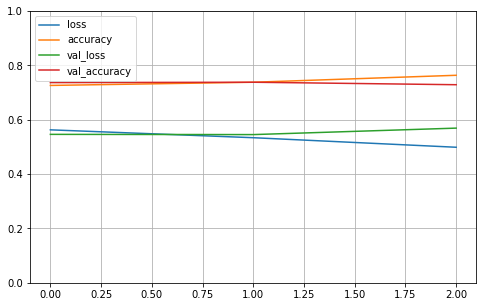

Compute valiation accuracy
2023-01-17 15:57:24.897704
Range of scores: 0.13671622 to 0.9885682
Predicted zeros and ones 244 2053
Accuracy: 72.88% Precision: 76.23% Recall: 92.06% F1: 83.40%
2023-01-17 15:57:30.666106
Fold 2
Training example
[147  73  35 ...   0   0   0]
Train sizes (9088, 2997) (9088, 1)
Valid sizes (2392, 2997) (2392, 1)
Train set ones/size 6618 / 9088
Valid set ones/size 1759 / 2392
BUILD MODEL
COMPILE
FIT
2023-01-17 15:57:33.126732
Epoch 1/3
284/284 [==============================] - 51s 171ms/step - loss: 0.5608 - accuracy: 0.7269 - val_loss: 0.5426 - val_accuracy: 0.7304
Epoch 2/3
284/284 [==============================] - 48s 168ms/step - loss: 0.5353 - accuracy: 0.7401 - val_loss: 0.5345 - val_accuracy: 0.7324
Epoch 3/3
284/284 [==============================] - 49s 172ms/step - loss: 0.4978 - accuracy: 0.7559 - val_loss: 0.5544 - val_accuracy: 0.7216


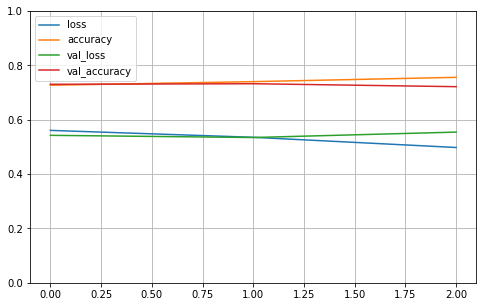

Compute valiation accuracy
2023-01-17 16:00:00.897102
Range of scores: 0.10914374 to 0.98994887
Predicted zeros and ones 365 2027
Accuracy: 72.16% Precision: 76.96% Recall: 88.69% F1: 82.41%
2023-01-17 16:00:06.837272
Fold 3
Training example
[147  73  35 ...   0   0   0]
Train sizes (9163, 2997) (9163, 1)
Valid sizes (2317, 2997) (2317, 1)
Train set ones/size 6646 / 9163
Valid set ones/size 1731 / 2317
BUILD MODEL
COMPILE
FIT
2023-01-17 16:00:09.306213
Epoch 1/3
287/287 [==============================] - 53s 172ms/step - loss: 0.5637 - accuracy: 0.7211 - val_loss: 0.5373 - val_accuracy: 0.7458
Epoch 2/3
287/287 [==============================] - 49s 170ms/step - loss: 0.5361 - accuracy: 0.7365 - val_loss: 0.5432 - val_accuracy: 0.7423
Epoch 3/3
287/287 [==============================] - 50s 173ms/step - loss: 0.5032 - accuracy: 0.7620 - val_loss: 0.5567 - val_accuracy: 0.7441


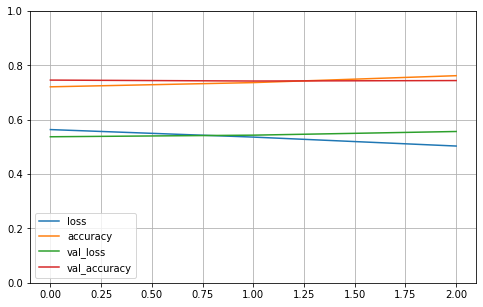

Compute valiation accuracy
2023-01-17 16:03:34.871943
Range of scores: 0.14404525 to 0.9879269
Predicted zeros and ones 141 2176
Accuracy: 74.41% Precision: 76.15% Recall: 95.73% F1: 84.82%
2023-01-17 16:03:45.790698
Fold 4
Training example
[147  73  35 ...   0   0   0]
Train sizes (9247, 2997) (9247, 1)
Valid sizes (2233, 2997) (2233, 1)
Train set ones/size 6820 / 9247
Valid set ones/size 1557 / 2233
BUILD MODEL
COMPILE
FIT
2023-01-17 16:03:48.260375
Epoch 1/3
289/289 [==============================] - 54s 178ms/step - loss: 0.5492 - accuracy: 0.7359 - val_loss: 0.5716 - val_accuracy: 0.7062
Epoch 2/3
289/289 [==============================] - 50s 173ms/step - loss: 0.5188 - accuracy: 0.7527 - val_loss: 0.5999 - val_accuracy: 0.7071
Epoch 3/3
289/289 [==============================] - 51s 177ms/step - loss: 0.4818 - accuracy: 0.7729 - val_loss: 0.6204 - val_accuracy: 0.6892


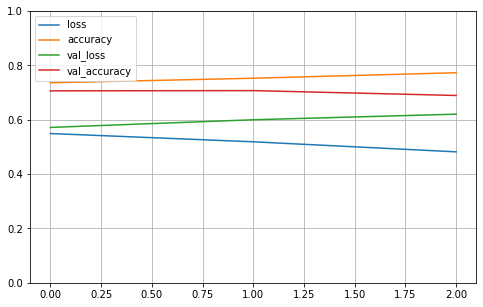

Compute valiation accuracy
2023-01-17 16:06:24.155097
Range of scores: 0.14049672 to 0.9920678
Predicted zeros and ones 272 1961
Accuracy: 68.92% Precision: 72.00% Recall: 90.69% F1: 80.27%
2023-01-17 16:06:30.049020
Fold 5
Training example
[169 163 140 ...   0   0   0]
Train sizes (9239, 2997) (9239, 1)
Valid sizes (2241, 2997) (2241, 1)
Train set ones/size 6747 / 9239
Valid set ones/size 1630 / 2241
BUILD MODEL
COMPILE
FIT
2023-01-17 16:06:32.470582
Epoch 1/3
289/289 [==============================] - 55s 179ms/step - loss: 0.5632 - accuracy: 0.7287 - val_loss: 0.5626 - val_accuracy: 0.7224
Epoch 2/3
289/289 [==============================] - 50s 174ms/step - loss: 0.5218 - accuracy: 0.7477 - val_loss: 0.5640 - val_accuracy: 0.7202
Epoch 3/3
289/289 [==============================] - 50s 174ms/step - loss: 0.4849 - accuracy: 0.7745 - val_loss: 0.5781 - val_accuracy: 0.7059


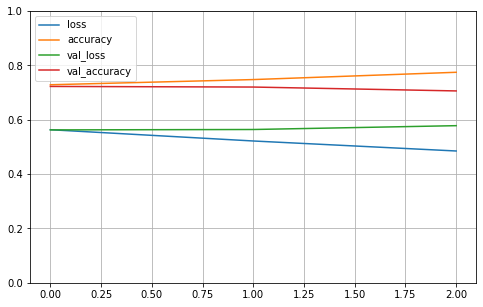

Compute valiation accuracy
2023-01-17 16:09:57.485526
Range of scores: 0.09910076 to 0.99298215
Predicted zeros and ones 352 1889
Accuracy: 70.59% Precision: 75.70% Recall: 87.73% F1: 81.27%
2023-01-17 16:10:03.445885

Cross validation 5 folds 3 epochs
 accuracy mean 71.79% +/- 1.89
 precision mean 75.41% +/- 1.75
 recall mean 90.98% +/- 2.81
 F1 mean 82.44% +/- 1.59
2023-01-17 16:10:03.448081


In [40]:
print(datetime.now())
cvdo = CrossValidator(EPOCHS,FOLDS,BREAK)
cv_accuracy, cv_precision, cv_recall, cv_f1 = cvdo.do_cross_validation()   
print("Cross validation %d folds %d epochs" % (FOLDS,EPOCHS)) 
print(" accuracy mean %.2f%% +/- %.2f" % (np.mean(cv_accuracy), np.std(cv_accuracy)))
print(" precision mean %.2f%% +/- %.2f" % (np.mean(cv_precision), np.std(cv_precision)))
print(" recall mean %.2f%% +/- %.2f" % (np.mean(cv_recall), np.std(cv_recall)))
print(" F1 mean %.2f%% +/- %.2f" % (np.mean(cv_f1), np.std(cv_f1)))
print(datetime.now())